In [27]:
import mechanicalsoup
from bs4 import BeautifulSoup
import pandas as pd


# Enter Player Name
player_name = "Phil-Foden"

col_names = ['Day',
             'Comp',
             'Round',
             'Venue',
             'Result',
             'Squad',
             'Opponent',
             'Start',
             'Pos',
             'Min',
             'Gls',
             'Ast',
             'PK',
             'PKatt',
             'Sh',
             'SoT',
             'CrdY',
             'CrdR',
             'Touches',
             'Tkl',
             'Int',
             'Blocks',
             'xG',
             'npxG',
             'xAG',
             'SCA',
             'GCA',
             'Cmp',
             'Pass_Att',
             'Cmp%',
             'PrgP',
             'Carries',
             'PrgC',
             'TakeOns_Att',
             'Succ',
             'Match Report']
        

def yearly_url_func(year):
    base_url = "https://fbref.com/en/players/e342ad68/matchlogs"
    
    url = f"{base_url}/{year}/{player_name}-Match-Logs"
    
    return url


def scrape_data_for_year(year):
    browser = mechanicalsoup.StatefulBrowser()
    url = yearly_url_func(year)
    
    try:
        browser.open(url)
        # Scraping the data for the given year
        
        th_elements = browser.page.find_all("th", attrs={"class": 'left'})
        
        filtered_th_elements = [th for th in th_elements if "iz" not in th.get("class", [])]

    
        Date = [value.text for value in filtered_th_elements] # We're only interested in the text not text plus tags
    
        td_elements = browser.page.find_all("td", attrs={"class": lambda x: x and 'left iz' not in x and 'left iz group_start' not in x and 'center iz' not in x})
        
        filtered_td_elements = [td for td in td_elements]
        
        columns = [value.text for value in filtered_td_elements]
        
                
        consistent_occurrences = []
        target_gap = 36  # We have a total of 36 columns

        # Iterate through the list and find occurrences
        for i in range(len(columns)):
            if columns[i] == 'Match Report':
                consistent_occurrences.append(i)

        # Create a list to store rows
        consistent_rows = []

        # Process only the last occurrence in each group
        for occurrence in consistent_occurrences:
            start_index = occurrence - target_gap + 1
            if start_index >= 0:
                consistent_rows.append(columns[start_index:occurrence + 1])

        # Create a DataFrame with column names
        df = pd.DataFrame(consistent_rows, columns=col_names)
        df.index = df.index +1
        return df  # Return the DataFrame
    
    
    except Exception as e:
        print(f"Error scraping data for {year}: {e}")
        return None
    
    finally:
        browser.close()

# Example usage:
years = ["2016-2017","2017-2018","2018-2019","2019-2020","2020-2021","2021-2022", "2022-2023"]

# Create an empty list to store DataFrames
dfs = []

for year in years:
    df = scrape_data_for_year(year)
    if df is not None:  # Check if the DataFrame is not None
        dfs.append(df)

# Concatenate the DataFrames if the list is not empty
if dfs:
    final_df = pd.concat(dfs, axis=0, ignore_index=True)
    
    # DATA PREPROCESSING LOGIC   
    
    # Removing rows with non-date values in Days Column
    days_to_keep = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    final_df = final_df[final_df['Day'].isin(days_to_keep)]
    
    #Filtering for only Premier League
    final_df = final_df[final_df['Comp'] == 'Premier League']
    
    
    # Save the final DataFrame
    final_df.to_csv(f"{player_name}.csv", index = False, encoding='utf-8')
    
    
    
else:
    print("No data available.")


In [28]:
#Since every data type was intially object, we need to ensure we have int where we only have integers
numeric_columns = ['Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA', 'GCA', 'Cmp', 'Pass_Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'TakeOns_Att', 'Succ']

final_df[numeric_columns] = final_df[numeric_columns].apply(pd.to_numeric, errors='coerce')


In [29]:
final_df.dtypes

Day              object
Comp             object
Round            object
Venue            object
Result           object
Squad            object
Opponent         object
Start            object
Pos              object
Min               int64
Gls               int64
Ast               int64
PK                int64
PKatt             int64
Sh                int64
SoT               int64
CrdY              int64
CrdR              int64
Touches           int64
Tkl               int64
Int               int64
Blocks            int64
xG              float64
npxG            float64
xAG             float64
SCA               int64
GCA               int64
Cmp               int64
Pass_Att          int64
Cmp%            float64
PrgP              int64
Carries           int64
PrgC              int64
TakeOns_Att       int64
Succ              int64
Match Report     object
dtype: object

In [30]:
final_df.columns

Index(['Day', 'Comp', 'Round', 'Venue', 'Result', 'Squad', 'Opponent', 'Start',
       'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA', 'GCA',
       'Cmp', 'Pass_Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'TakeOns_Att',
       'Succ', 'Match Report'],
      dtype='object')

In [31]:
from sklearn.preprocessing import LabelEncoder

#Will have little variance since they are the same throughout the rows
columns_to_drop = ['Comp', 'Squad', 'CrdY', 'CrdR', 'Match Report']
final_df = final_df.drop(columns=columns_to_drop)


In [32]:
le = LabelEncoder()

# Use the remaining columns for label encoding
for column in final_df.columns:
    if final_df[column].dtype == 'object':
        final_df[column] = le.fit_transform(final_df[column])


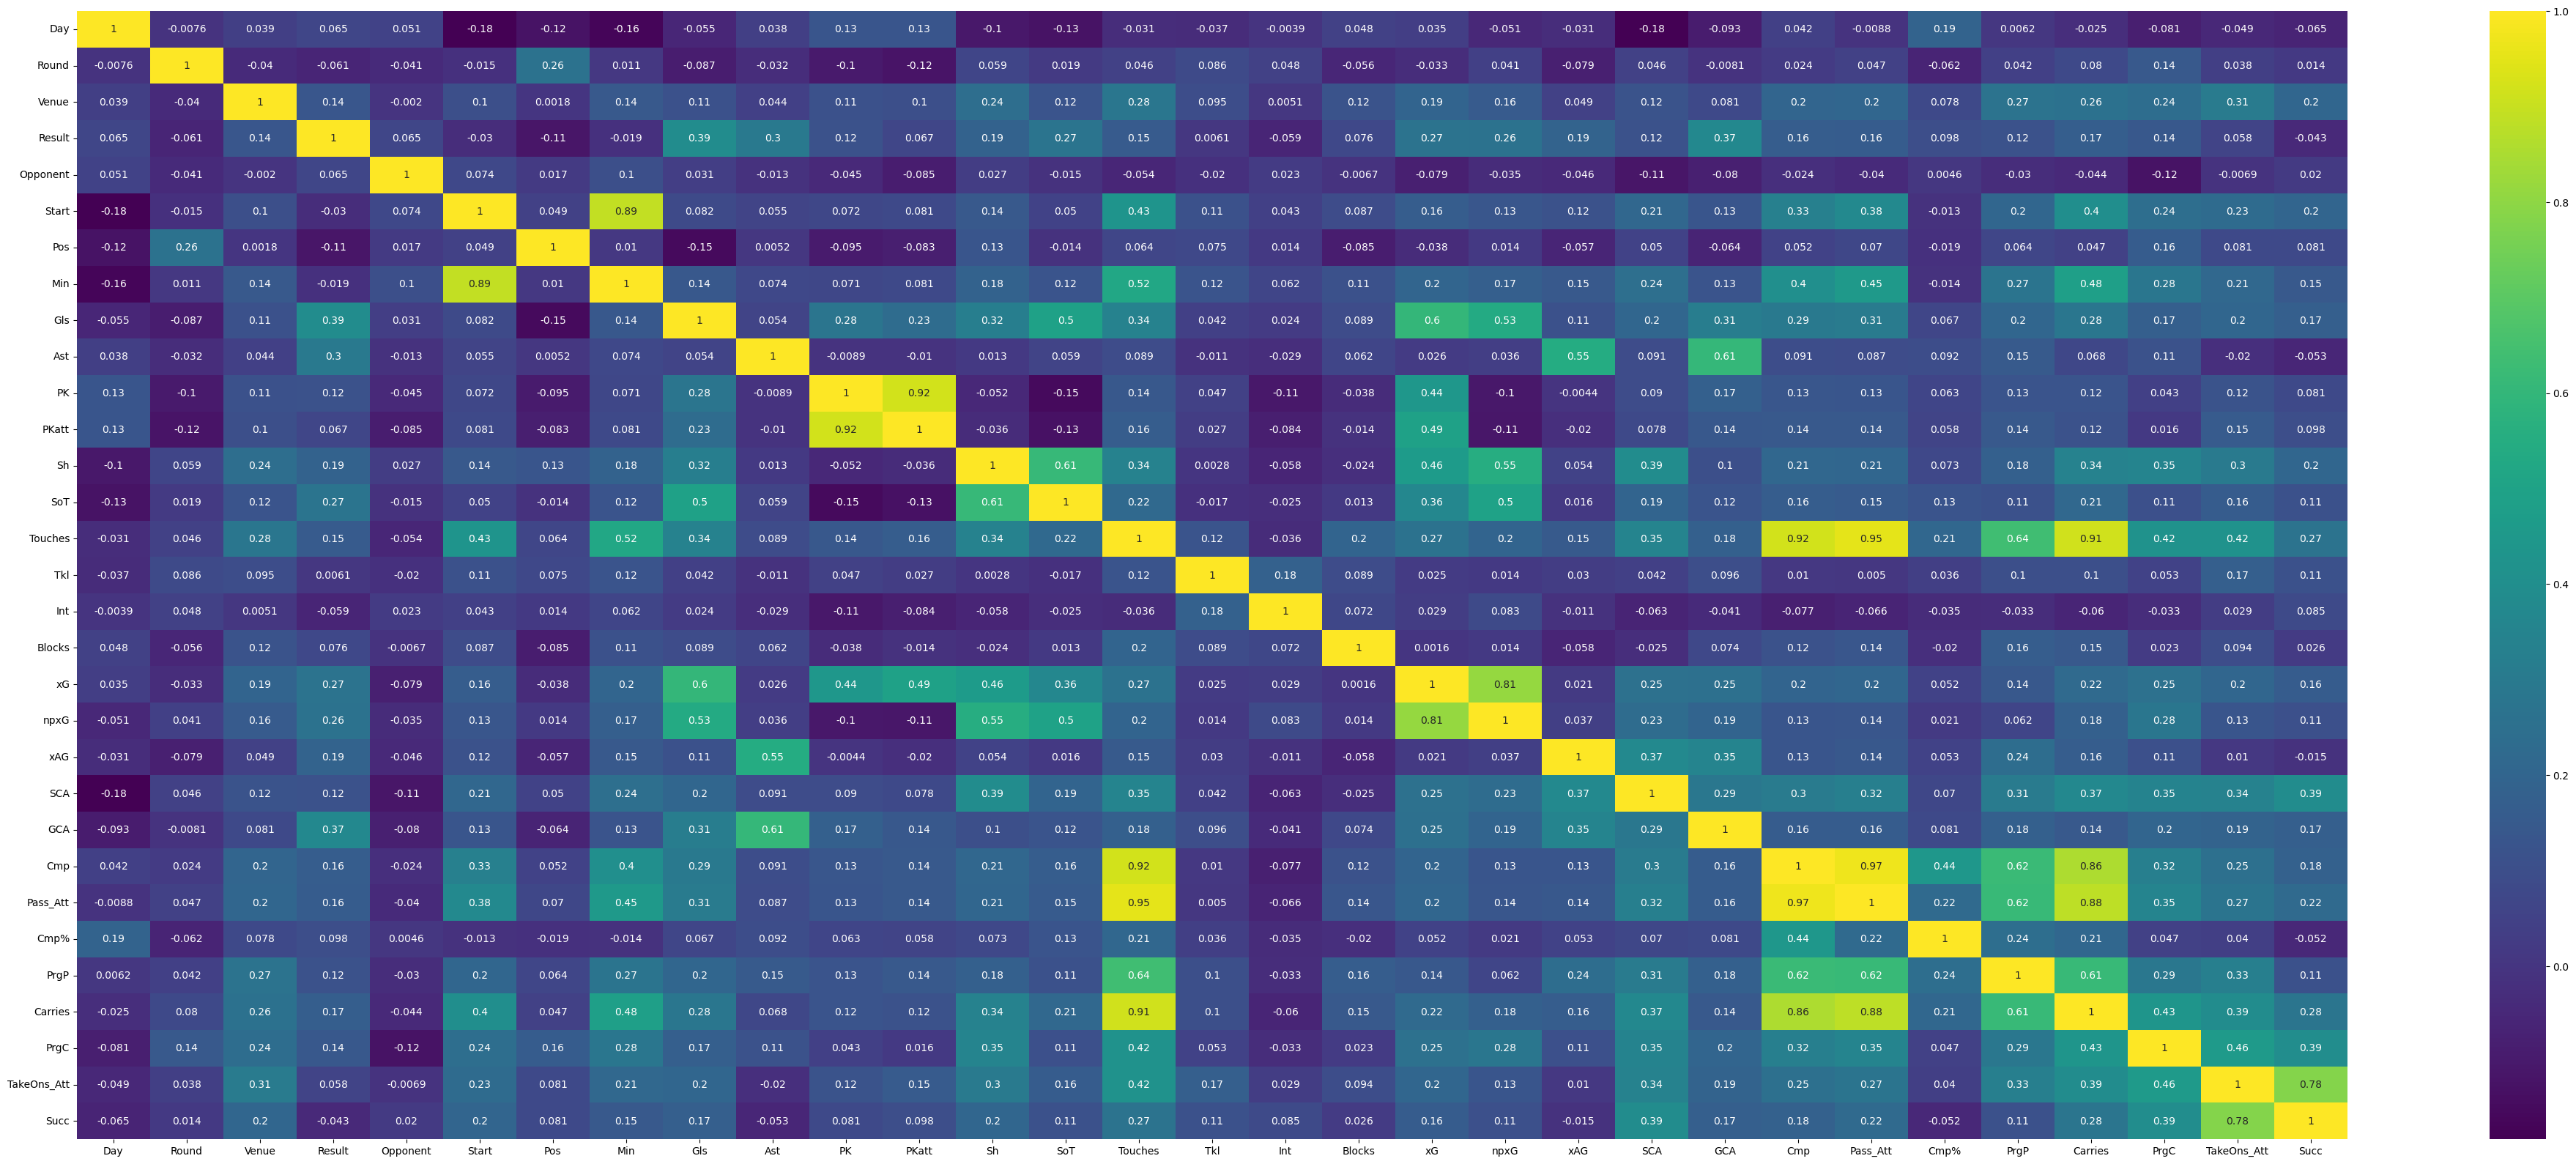

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = final_df.corr()
plt.figure(figsize=(50,20))
sns.heatmap(correlation_matrix, annot = True, cmap = 'viridis')

plt.show()